# Creating river forcing

In [1]:
from roms_tools import RiverForcing, Grid

We first create our grid object. In this example, our domain lives in the North Atlantic and surrounds Iceland.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=800, size_y=800, center_lon=-18, center_lat=65, rot=20
)

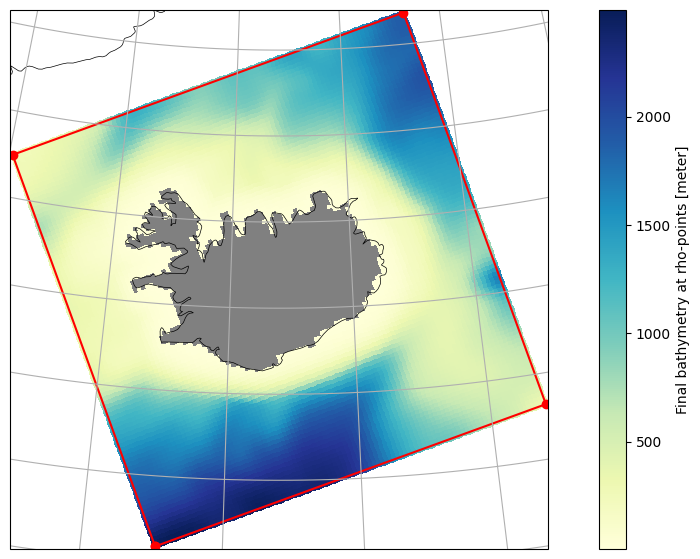

In [3]:
grid.plot(bathymetry=True)

We aim to generate river forcing data for the years 1998, 1999, and 2000.

In [4]:
from datetime import datetime

In [5]:
start_time = datetime(1998, 1, 1)
end_time = datetime(2000, 12, 31)

In [6]:
%%time

river_forcing = RiverForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
)

INFO - Compute climatology for river forcing.


CPU times: user 648 ms, sys: 200 ms, total: 847 ms
Wall time: 2.19 s


<div class="alert alert-info">

Note

The river forcing dataset includes a parameter called `source`. If this parameter is not specified by the user, it defaults to the **Dai and Trenberth global river dataset** (updated in May 2019), which provides monthly time series for approximately 1,000 rivers worldwide, dating back to the year 1900. This default dataset is downloaded internally, meaning the user does not need to provide a file path or filename. 
    
You can also include your own river dataset by specifying the `source` parameter as follows:

```
source = {
    "name": "DAI",
    "path": "path/to/file",
    "climatology": True / False
}
```
where the dataset at `"path/to/file"` should have the variables (and variable names) required in the Dai and Trenberth river dataset. For more details on the required variables and their names, refer to the [documentation here](https://roms-tools.readthedocs.io/en/latest/datasets.html).

If your dataset does not conform to these specifications, please feel free to open a pull request or issue for a feature request.

</div>

The river forcing variables are held in an `xarray.Dataset` object returned by the `.ds` property.

In [7]:
river_forcing.ds

<xarray.Dataset> Size: 1kB
Dimensions:       (river_time: 12, nriver: 6, ntracers: 2)
Coordinates:
    month         (river_time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    river_name    (nriver) object 48B 'Hvita(Olfusa)' 'Thjorsa' ... 'Svarta'
    tracer_name   (ntracers) <U11 88B 'temperature' 'salinity'
    abs_time      (river_time) datetime64[ns] 96B 2000-01-16 ... 2000-12-15
  * river_time    (river_time) float64 96B 15.0 45.0 74.0 ... 288.0 319.0 349.0
Dimensions without coordinates: nriver, ntracers
Data variables:
    river_volume  (river_time, nriver) float32 288B 396.0 273.3 ... 38.2 8.47
    river_tracer  (river_time, ntracers, nriver) float32 576B 17.0 17.0 ... 1.0
Attributes:
    climatology:  True

We will examine these river forcing variables in more detail later.

## River locations

Let's plot the river locations extracted from the global dataset that are relevant to our domain!

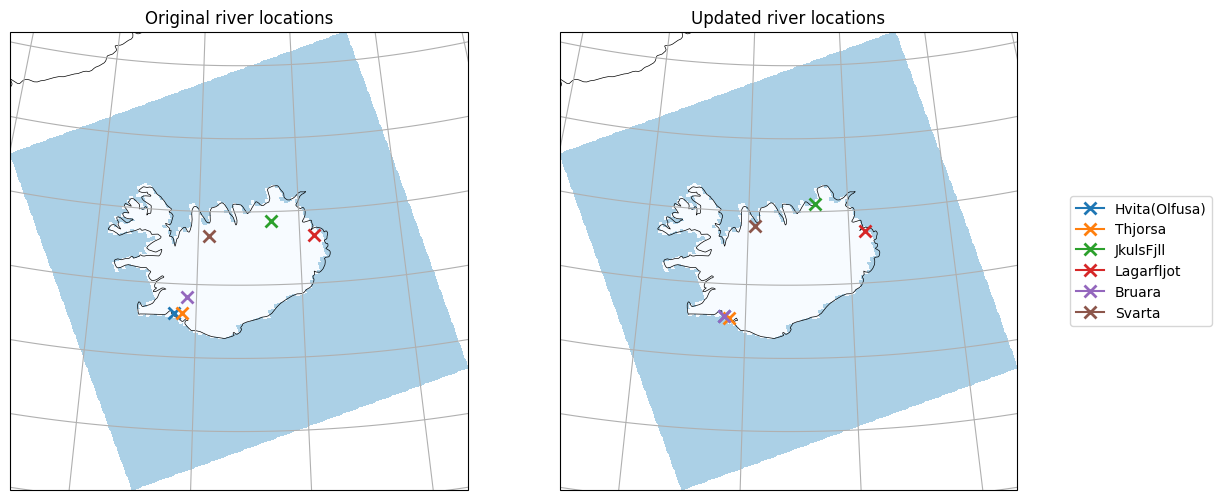

In [8]:
river_forcing.plot_locations()

The left plot shows the original river locations extracted from the global dataset, mapped onto the ROMS domain. However, you will notice that most of these locations do not lie along the coast. ROMS requires river locations to be placed on land, but adjacent to wet points. The right plot displays the updated river locations, where `ROMS-Tools` has moved the original points to the nearest coastal grid points. These updated coastal river locations are now reflected as a new variable `river_flux` in the grid dataset.

In [9]:
grid.ds

<xarray.Dataset> Size: 26MB
Dimensions:              (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101,
                          eta_coarse: 52, xi_coarse: 52, s_rho: 100, s_w: 101)
Coordinates: (12/14)
    lat_rho              (eta_rho, xi_rho) float64 83kB 60.27 60.3 ... 69.55
    lon_rho              (eta_rho, xi_rho) float64 83kB 337.6 337.8 ... 348.2
    lat_u                (eta_rho, xi_u) float64 82kB 60.28 60.31 ... 69.54
    lon_u                (eta_rho, xi_u) float64 82kB 337.7 337.8 ... 348.1
    lat_v                (eta_v, xi_rho) float64 82kB 60.3 60.33 ... 69.5 69.51
    lon_v                (eta_v, xi_rho) float64 82kB 337.6 337.7 ... 348.2
    ...                   ...
    layer_depth_rho      (s_rho, eta_rho, xi_rho) float32 4MB 2.44e+03 ... 1.31
    layer_depth_u        (s_rho, eta_rho, xi_u) float32 4MB 2.44e+03 ... 1.31
    layer_depth_v        (s_rho, eta_v, xi_rho) float32 4MB 2.44e+03 ... 1.31
    interface_depth_rho  (s_w, eta_rho, xi_rho) float32 4MB 2.459e+03 ... -0.0
    interface_depth_u    (s_w, eta_rho, xi_u) float32 4MB 2.459e+03 ... -0.0
    interface_depth_v    (s_w, eta_v, xi_rho) float32 4MB 2.459e+03 ... -0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/14)
    angle                (eta_rho, xi_rho) float64 83kB 0.4167 0.4167 ... 0.2543
    f                    (eta_rho, xi_rho) float64 83kB 0.0001263 ... 0.0001363
    pm                   (eta_rho, xi_rho) float64 83kB 0.0001252 ... 0.0001252
    pn                   (eta_rho, xi_rho) float64 83kB 0.0001253 ... 0.0001253
    spherical            |S1 1B b'T'
    mask_rho             (eta_rho, xi_rho) int32 42kB 1 1 1 1 1 1 ... 1 1 1 1 1
    ...                   ...
    h                    (eta_rho, xi_rho) float64 83kB 2.459e+03 ... 1.884e+03
    angle_coarse         (eta_coarse, xi_coarse) float64 22kB 0.4163 ... 0.2547
    mask_coarse          (eta_coarse, xi_coarse) int32 11kB 1 1 1 1 ... 1 1 1 1
    Cs_r                 (s_rho) float32 400B -0.992 -0.9753 ... -9.874e-06
    Cs_w                 (s_w) float32 404B -1.0 -0.9837 ... -3.95e-05 0.0
    river_flux           (eta_rho, xi_rho) int32 42kB 0 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev277+dirty
    size_x:              800
    size_y:              800
    center_lon:          -18
    center_lat:          65
    rot:                 20
    topography_source:   ETOPO5
    hmin:                5.0
    theta_s:             5.0
    theta_b:             2.0
    hc:                  300.0

<div class="alert alert-info">

Note on the variable river_flux

The name `river_flux` is the one expected by ROMS, but it may be misleading because the variable represents river locations rather than the actual river flux. The `river_flux` variable contains zeros where no river is present. When a grid point represents a river, it is assigned a non-zero value according to the following partitioning rule:

```
    river_flux = river ID + fraction of the river's flux through the grid point.
```
For example, if River 3 spans 2 grid points, with half of its flux passing through each, the resulting value for `river_flux` at these points would be 3.5 (i.e., 3 + 0.5 for each grid point). This method allows the model to accurately represent rivers that span multiple grid points, ensuring that the river flux volume is correctly distributed over the multiple grid points.

If a river is confined to a single grid point (as is the case with what is created by `ROMS-Tools`), the `river_flux` will have a value of river ID + 1. For instance, if River 3 is located at a single grid point, the `river_flux` value will be 4.

</div>

In [10]:
import matplotlib.colors as mcolors

colors = ["gray", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
cmap = mcolors.ListedColormap(colors)

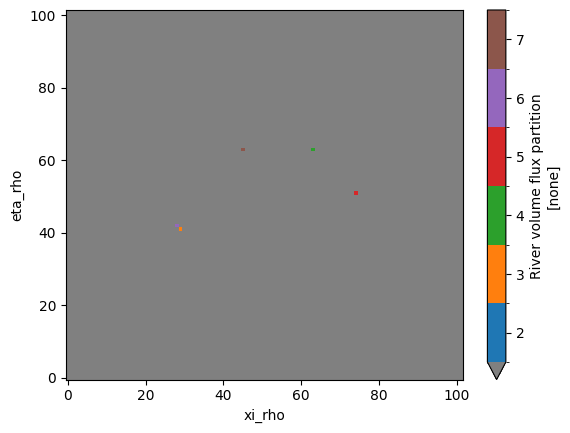

In [11]:
grid.ds.river_flux.plot(
    levels=7, vmin=1.5, vmax=7.5, cmap=cmap, cbar_kwargs={"ticks": [2, 3, 4, 5, 6, 7]}
)

If you squint your eyes, you can see that the river locations in the `river_flux` variable align with the updated river locations shown in the previous plot on the right, marked with the same colors.

## Monthly versus climatological river forcing

Many river datasets contain missing values. To address this, `ROMS-Tools` offers the option to replace missing monthly values with climatological averages. 

In this first example, we choose the option to never use climatological values, ensuring that the river forcing is derived entirely from the available monthly data.

In [12]:
%%time

river_forcing = RiverForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    convert_to_climatology="never",  # "never", "always", or "if_any_missing" (default)
)

WARNING - NaN values detected in the 'river_volume' field. These values are being set to zero. This may indicate missing river data, which could affect model accuracy. Consider setting `convert_to_climatology = 'if_any_missing'` to automatically fill missing values with climatological data.


CPU times: user 670 ms, sys: 160 ms, total: 830 ms
Wall time: 3.36 s


As we saw earlier in the notebook, the river forcing data is stored in an `xarray.Dataset`, which can be accessed via the `.ds` property.

In [13]:
river_forcing.ds

<xarray.Dataset> Size: 3kB
Dimensions:       (nriver: 6, river_time: 38, ntracers: 2)
Coordinates:
    river_name    (nriver) object 48B 'Hvita(Olfusa)' 'Thjorsa' ... 'Svarta'
    tracer_name   (ntracers) <U11 88B 'temperature' 'salinity'
    abs_time      (river_time) datetime64[ns] 304B 1997-12-15 ... 2001-01-15
  * river_time    (river_time) float64 304B -747.0 -716.0 -685.0 ... 349.0 380.0
Dimensions without coordinates: nriver, ntracers
Data variables:
    river_volume  (river_time, nriver) float32 912B 0.0 0.0 0.0 ... 0.0 0.0
    river_tracer  (river_time, ntracers, nriver) float32 2kB 17.0 17.0 ... 1.0

As mentioned in the warning message when we created the river forcing, some of the river volume data contained NaN values, which have since been set to zero. Let’s take a closer look at this.

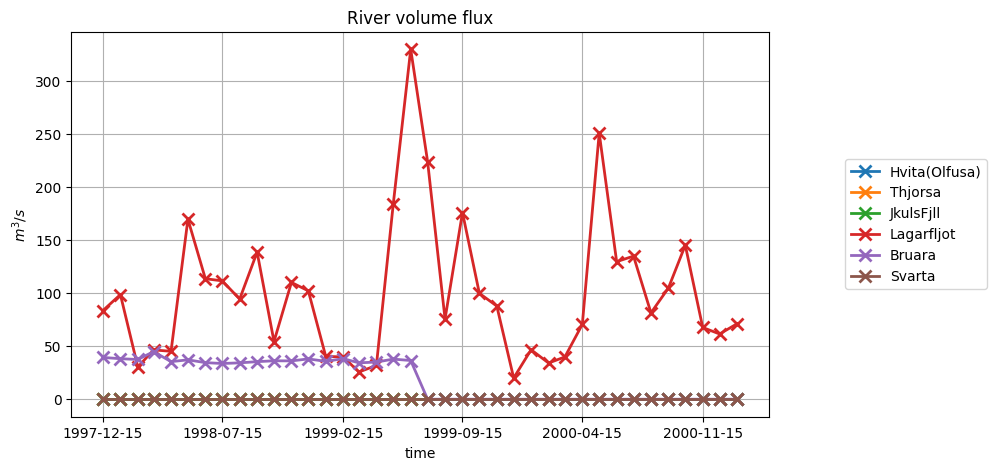

In [14]:
river_forcing.plot("river_volume")

Only the river Lagarfljot (red line) has a complete time series over our period of interest. The river Bruara (purple line) has missing values for roughly the second half of the period, which have been set to zero. All other rivers have missing values for the entire period and have also been set to zero.

The river tracer data, consisting of the river temperature and salinity, are not derived from the Dai and Trenberth dataset. Instead, they are always set to constant values: 17°C for temperature and 1 psu for salinity.

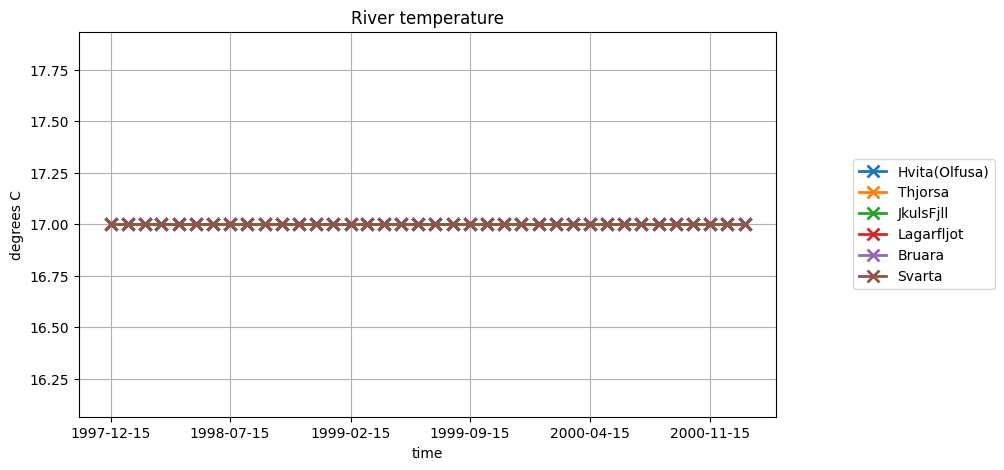

In [15]:
river_forcing.plot("river_temperature")

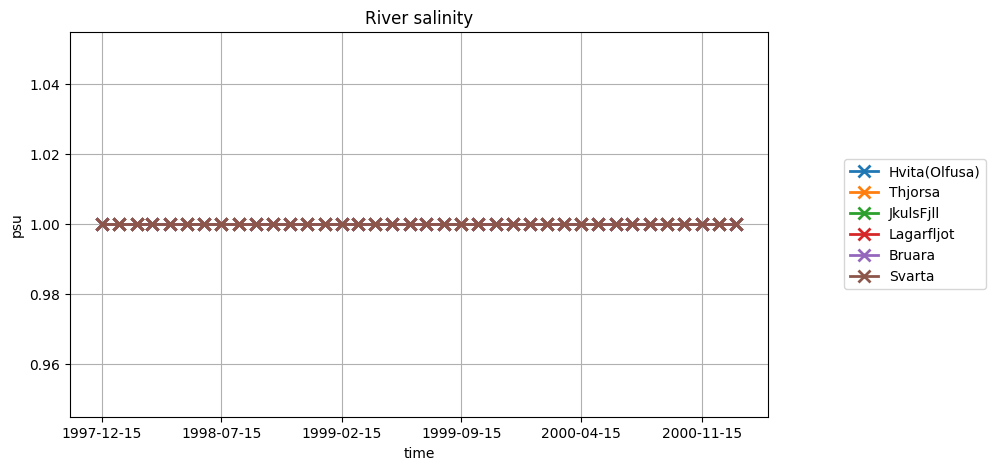

In [16]:
river_forcing.plot("river_salinity")

We will now select the default option in `ROMS-Tools`, which converts the river volume data to climatological values if any missing values are detected.

In [17]:
%%time

river_forcing = RiverForcing(
    grid=grid,
    start_time=datetime(1998, 1, 1),
    end_time=datetime(2000, 12, 31),
    convert_to_climatology="if_any_missing",  # "never", "always", or "if_any_missing" (default)
)

INFO - Compute climatology for river forcing.


CPU times: user 675 ms, sys: 169 ms, total: 844 ms
Wall time: 2.2 s


The river forcing for all rivers is now represented as a climatology. Note that none of the rivers has a zero river volume flux in any month!

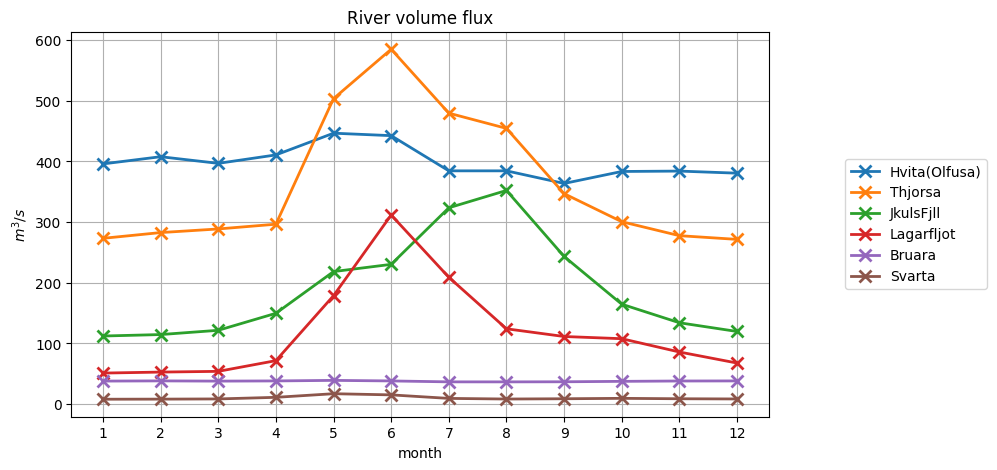

In [18]:
river_forcing.plot("river_volume")

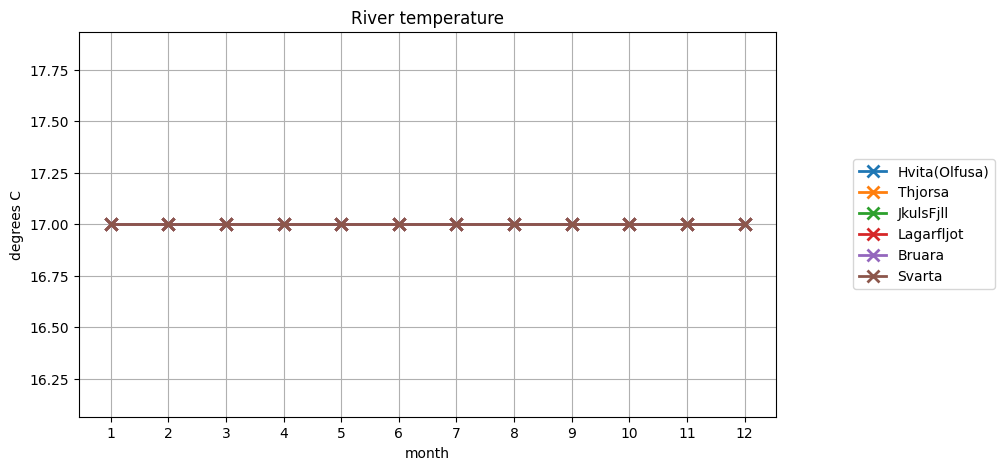

In [19]:
river_forcing.plot("river_temperature")

## Saving as NetCDF or YAML file

We can now save our river forcing as a netCDF file via the `.save` method. Since the `river_flux` variable has been added, the grid file must also be resaved.

In [20]:
filepath = "/pscratch/sd/n/nloose/forcing/my_river_forcing.nc"
filepath_grid = "/pscratch/sd/n/nloose/grids/my_roms_grid.nc"

In [21]:
river_forcing.save(filepath=filepath, filepath_grid=filepath_grid)

[PosixPath('/pscratch/sd/n/nloose/forcing/my_river_forcing.nc'),
 PosixPath('/pscratch/sd/n/nloose/grids/my_roms_grid.nc')]

We can also export the river forcing parameters to a YAML file.

In [22]:
yaml_filepath = "/pscratch/sd/n/nloose/forcing/my_river_forcing.yaml"

In [23]:
river_forcing.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [24]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev277+dirty
---
Grid:
  nx: 100
  ny: 100
  size_x: 800
  size_y: 800
  center_lon: -18
  center_lat: 65
  rot: 20
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source: ETOPO5
  hmin: 5.0
RiverForcing:
  start_time: '1998-01-01T00:00:00'
  end_time: '2000-12-31T00:00:00'
  source:
    name: DAI
    climatology: false
  convert_to_climatology: if_any_missing
  model_reference_date: '2000-01-01T00:00:00'



## Creating river forcing from an existing YAML file

In [25]:
%time the_same_river_forcing = RiverForcing.from_yaml(yaml_filepath)

INFO - Compute climatology for river forcing.


CPU times: user 2.08 s, sys: 347 ms, total: 2.43 s
Wall time: 5.17 s
